In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xs = np.linspace(0, 1, num=16)
ys = np.sin(xs * np.pi * 4) + np.random.normal(loc=0, scale=0.5, size=len(xs))

# Models and Training code

In [4]:
def train(network, xs, ys, epochs, lr, plot_freq=10, batch_size=32):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    for i in range(epochs):
        indices = np.arange(len(xs))
        np.random.shuffle(indices)
        for batch_i in range(len(xs) // batch_size + bool(len(xs) % batch_size)):
            optimizer.zero_grad()
            curr_idx = indices[batch_i * batch_size: (batch_i + 1) * batch_size]
            pred = network(xs[curr_idx])
            loss = F.mse_loss(pred, ys[curr_idx])
            loss.backward()
            optimizer.step()
        if i % plot_freq == 0:
            with torch.no_grad():
                pred = network(xs)
            plt.plot(xs, pred.detach().numpy(), label=str(i))
    with torch.no_grad():
                pred = network(xs)
    plt.plot(xs, pred.detach().numpy(), label='learned')
    plt.plot(xs, ys, label='ground truth', linestyle='--')
    plt.legend()
    plt.show()

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=1, hidden_dim=512, first_dim=0, add_tanh=False):
        super().__init__()

        first_dim = max(hidden_dim, first_dim)
        layers = [nn.Linear(input_size, first_dim), nn.ReLU()]
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(first_dim, hidden_dim))
            first_dim = hidden_dim
            layers.append(nn.ReLU())
        layers.append(nn.Linear(first_dim, output_size))
        if add_tanh:
            layers.append(nn.Tanh())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(len(x), -1)  # flatten
        return self.mlp.forward(x)


class FourierMLP(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 n_hidden=1,
                 hidden_dim=512,
                 sigma=1.0,
                 fourier_dim=512,
                 train_B=False,
                 concatenate_fourier=False,
                 add_tanh=False):
        super().__init__()

        # create B
        b_shape = (input_size, fourier_dim // 2)
        self.sigma = sigma
        self.B = nn.Parameter(torch.normal(torch.zeros(*b_shape), torch.full(b_shape, sigma)))
        self.B.requires_grad = train_B

        self.concatenate_fourier = concatenate_fourier
        if self.concatenate_fourier:
            mlp_input_dim = fourier_dim + input_size
        else:
            mlp_input_dim = fourier_dim

        # create rest of the network
        layers = [nn.Linear(mlp_input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_size))
        if add_tanh:
            layers.append(nn.Tanh())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: tensor of shape [batch_size, input_size]
        :return: logits: tensor of shape [batch_size, n_classes]
        """
        x = x.view(len(x), -1)  # flatten
        # create fourier features
        proj = (2 * np.pi) * torch.matmul(x, self.B)
        if self.concatenate_fourier:
            ff = torch.cat([x, torch.sin(proj), torch.cos(proj)], dim=-1)
        else:
            ff = torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        return self.mlp.forward(ff)

# Training

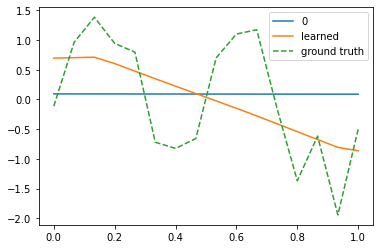

In [6]:

ff_mlp1 = FourierMLP(1, 1, n_hidden=3, hidden_dim=256, sigma=0.01, train_B=False)
train(ff_mlp1, torch.tensor(xs).float().reshape(-1, 1), torch.tensor(ys).float().reshape(-1, 1), 500, 1e-4, plot_freq=500)

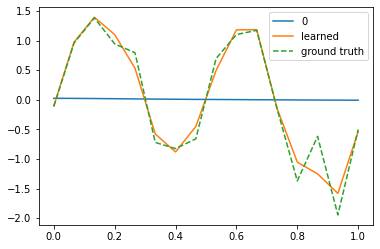

In [7]:

ff_mlp2 = FourierMLP(1, 1, n_hidden=3, hidden_dim=256, sigma=0.1, train_B=False)
train(ff_mlp2, torch.tensor(xs).float().reshape(-1, 1), torch.tensor(ys).float().reshape(-1, 1), 500, 1e-4, plot_freq=500)

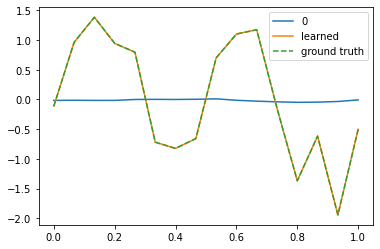

In [8]:

ff_mlp3 = FourierMLP(1, 1, n_hidden=3, hidden_dim=256, sigma=1.0, train_B=False)
train(ff_mlp3, torch.tensor(xs).float().reshape(-1, 1), torch.tensor(ys).float().reshape(-1, 1), 500, 1e-4, plot_freq=500)

# Plotting

In [ ]:
ys1 = ff_mlp1(torch.linspace(0, 1, 100))
ys2 = ff_mlp2(torch.linspace(0, 1, 100))
ys3 = ff_mlp3(torch.linspace(0, 1, 100))

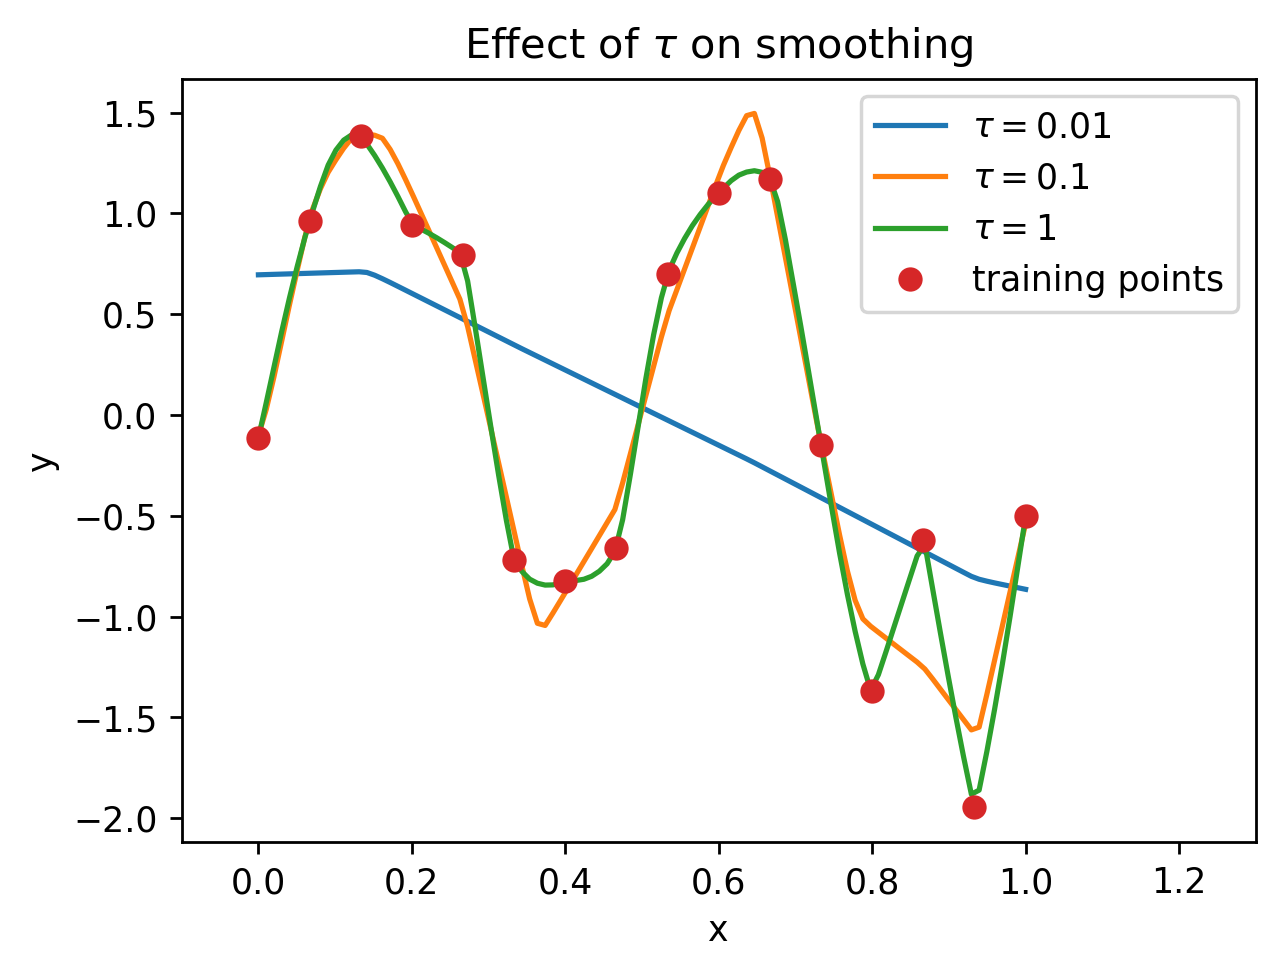

In [10]:
plt.figure(dpi=250, figsize=(6.4/1.3, 4.8/1.3))
plt.plot(np.linspace(0, 1, 100), ys1.detach().numpy(), label='$\\tau=0.01$')
plt.plot(np.linspace(0, 1, 100), ys2.detach().numpy(), label='$\\tau=0.1$')
plt.plot(np.linspace(0, 1, 100), ys3.detach().numpy(), label='$\\tau=1$')
plt.plot(xs, ys, 'o', label='training points')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.1, 1.3)
plt.legend(loc=1)
plt.title('Effect of $\\tau$ on smoothing')
plt.tight_layout(pad=0)
# plt.show()
plt.savefig('1d.pdf')